In [4]:
# Import Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import warnings

from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras import applications
import os
import glob

import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D
from keras.layers import AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPool2D,MaxPooling2D,MaxPool2D,Dropout
from keras.models import Model,Sequential

2025-04-16 10:23:16.129188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
data_dir = '/Users/Zeeshan/Documents/UofT ML Course/Project/uoft-ml-sports/data'

In [6]:
train = glob.glob(data_dir + '/train/*')
train_class=os.listdir(data_dir + '/train')


In [10]:
count_dict1 = {}
img_dict1 = {}

# Loop through classes
for cls in train_class:  # Assuming class_names contains the list of dog classes
    image_path = glob.glob(data_dir + f'/train/{cls}/*')
    count_dict1[cls] = len(image_path)

    if image_path:  # Check if image_path is not empty
        img_dict1[cls] = tf.keras.utils.load_img(random.choice(image_path))
count_dict1

{'lacrosse': 151,
 'shuffleboard': 130,
 'arm wrestling': 99,
 'golf': 157,
 'surfing': 142,
 'snow boarding': 117,
 'parallel bar': 131,
 'pole climbing': 118,
 'giant slalom': 150,
 'bobsled': 138,
 'baton twirling': 108,
 'weightlifting': 134,
 'hydroplane racing': 108,
 'barell racing': 123,
 'water cycling': 103,
 '.DS_Store': 0,
 'mushing': 111,
 'uneven bars': 156,
 'pole vault': 138,
 'roller derby': 163,
 'rowing': 143,
 'jousting': 118,
 'air hockey': 112,
 'sky surfing': 59,
 'shot put': 149,
 'sidecar racing': 133,
 'field hockey': 157,
 'harness racing': 147,
 'disc golf': 123,
 'canoe slamon': 164,
 'football': 191,
 'ski jumping': 130,
 'ice yachting': 112,
 'cricket': 129,
 'figure skating women': 157,
 'horse racing': 139,
 'baseball': 174,
 'billiards': 145,
 'bowling': 120,
 'motorcycle racing': 132,
 'javelin': 136,
 'fly fishing': 134,
 'bull riding': 149,
 'sumo wrestling': 133,
 'tug of war': 128,
 'figure skating men': 128,
 'sailboat racing': 144,
 'horse jumpi

In [11]:
df1 = pd.DataFrame(data={'label':count_dict1.keys(),'count':count_dict1.values()})
df1

,label,count
0,lacrosse,151
1,shuffleboard,130
2,arm wrestling,99
3,golf,157
4,surfing,142
...,...,...
96,track bicycle,135
97,chuckwagon racing,120
98,hurdles,136
99,horseshoe pitching,102


In [12]:
# Data Preprocessing

train_data = tf.keras.utils.image_dataset_from_directory(data_dir + '/train',label_mode='categorical',shuffle=False)
test_data = tf.keras.utils.image_dataset_from_directory(data_dir + '/test',shuffle=False,label_mode='categorical')
validation_data = tf.keras.utils.image_dataset_from_directory(data_dir + '/valid',label_mode='categorical',shuffle=False)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [13]:
width = 229
height = 229
channels = 3

data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(height, width),
    tf.keras.layers.Rescaling(1.0 / 255),
])

In [14]:
train_ds = train_data.map(lambda x,y:(data_preprocessing(x),y))
test_ds = test_data.map(lambda x,y:(data_preprocessing(x),y))
valid_ds = validation_data.map(lambda x,y:(data_preprocessing(x),y))

In [15]:
# Data Augmentation

batch_size = 40
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
  data_dir + '/train',  # this is the target directory
  target_size=(229, 229),  # all images will be resized 
  batch_size=batch_size,
  class_mode='categorical',
  shuffle = True,  seed = 42)  

val_datagen = ImageDataGenerator()

validation_generator = val_datagen.flow_from_directory(
  data_dir + '/valid',
  target_size=(229, 229),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle = False,seed = 42 )

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [57]:
batch_images, batch_labels = next(train_generator)

# Print the shape of the batch
print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)

Batch images shape: (40, 229, 229, 3)
Batch labels shape: (40, 100)


In [20]:
# EfficientNet Model

from tensorflow.keras.applications import EfficientNetB0
# Load the EfficientNetB0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(229, 229, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Create a new model
model = Sequential()
# Add the pre-trained EfficientNetB0 base model
model.add(base_model)
model.add(GlobalAveragePooling2D())
# Add a dense layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Add a dense layer with the number of output classes and softmax activation
model.add(Dense(100, activation='softmax'))


In [22]:
model

<Sequential name=sequential_1, built=True>

In [53]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [54]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

In [58]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision','Recall'])

history = model.fit(
  train_generator,
  epochs=10,
  validation_data=validation_generator,
  callbacks=[early_stopping, reduce_lr])

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - Precision: 0.8224 - Recall: 0.2397 - accuracy: 0.4578 - loss: 2.3917 - val_Precision: 0.9675 - val_Recall: 0.8920 - val_accuracy: 0.9360 - val_loss: 0.2701 - learning_rate: 0.0010
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - Precision: 0.9210 - Recall: 0.7831 - accuracy: 0.8526 - loss: 0.5151 - val_Precision: 0.9751 - val_Recall: 0.9400 - val_accuracy: 0.9560 - val_loss: 0.1543 - learning_rate: 0.0010
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 609s 2s/step - Precision: 0.9403 - Recall: 0.8547 - accuracy: 0.9001 - loss: 0.3492 - val_Precision: 0.9691 - val_Recall: 0.9400 - val_accuracy: 0.9540 - val_loss: 0.1576 - learning_rate: 0.0010
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 603s 2s/step - Precision: 0.9488 - Recall: 0.8886 - accuracy: 0.9197 - loss: 0.2728 - val_Precision: 0.9754 - val_Recall: 0.9500 - val_accuracy: 0.9660 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 603s 2s/step - Preci

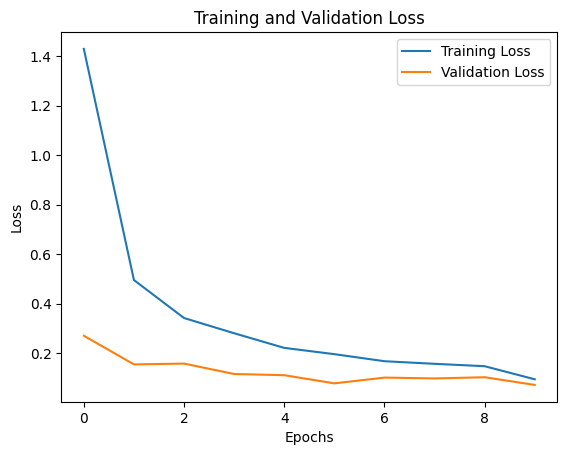

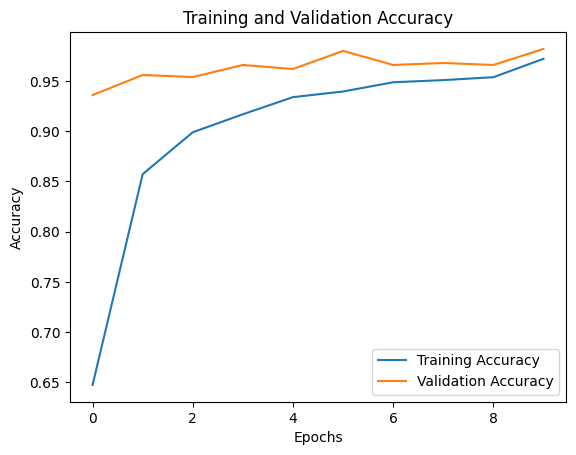

In [108]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

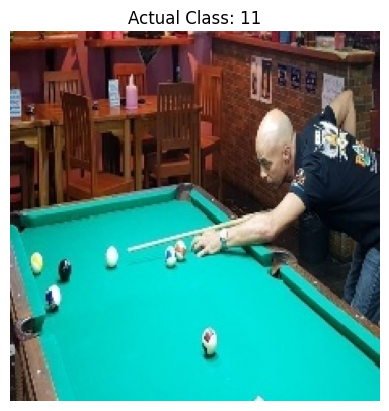

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Predicted Class Index: 25
Actual Class label: billiards
Predicted Class label: fencing


In [ ]:
# Get predictions and true labels

import matplotlib.pyplot as plt

# Get the first batch of images and labels from the validation generator
images, labels = next(validation_generator)
# Select the first image from the batch
test_image = images[18]
actual_label = labels[18]
actual_label_index = np.argmax(actual_label)  # Get the actual class index

# Display the first image
plt.imshow(test_image.astype("uint8"))  # Convert the image to uint8 for display
plt.axis('off')
plt.title("Actual Class: " + str(actual_label_index))  # Display the actual class index
plt.show()

# Preprocess the image (if necessary, depending on your model's input requirements)
test_image_batch = np.expand_dims(test_image, axis=0)  # Add batch dimension

# Predict the class using the model
predictions = model.predict(test_image_batch)
predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get the predicted class index

print(f"Predicted Class Index: {predicted_class_index}")

# Map the predicted index to the class label
class_indices = validation_generator.class_indices  # Get the mapping of class labels to indices
class_labels = {v: k for k, v in class_indices.items()}  # Reverse the mapping

print(f"Actual Class label: {class_labels[actual_label_index]}")
print(f"Predicted Class label: {class_labels[predicted_class_index]}")


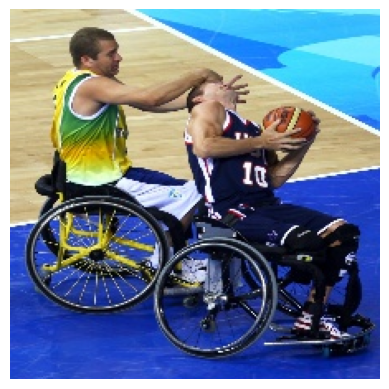

In [ ]:
from PIL import Image

import matplotlib.pyplot as plt

# Load and display the first image from our training data
image_path = train[75]+ "/010.jpg"
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

In [69]:
# Here we use the base model to predict the class of the image.
# We want to test if the predictions from the base model are similar to the labels we have in our dataset.
import torch
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification

preprocessor = EfficientNetImageProcessor.from_pretrained("google/efficientnet-b0")
original_model = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b0")

inputs = preprocessor(image, return_tensors="pt")

with torch.no_grad():
    logits = original_model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(original_model.config.id2label[predicted_label]),

tricycle, trike, velocipede


(None,)